# Maximisation couple moyen

Ce notebook propose d'optimiser le rotor d'une machine synchro-réluctante sans aimant à une paire de pôle en vue de maximiser le couple moyen.
Dans ce cas particulier, le couple moyen est directement relié à la différence de perméance magnétique du rotor dans l'axe direct d et l'axe en quadrature q.

Le problème étudié est donc la maximisation de cette différence de perméance via la différence de compliance magnétique. Il est possible de démontrer que ce problème est mal posé.

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
#from netgen.geom2d import unit_square
import copy
from numpy.random import randint
import numpy as np
import matplotlib.pyplot as plt

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage

La première étape consiste à définir une géométrie (disque), ainsi que la finesse de maillage associée.

In [2]:
#h = 0.1; # ne pas prendre moins de 1/50

#mesh = Mesh(unit_square.GenerateMesh(maxh=h))
#Draw (mesh)

In [3]:
geo = SplineGeometry()

R = 1.;
h = R/30; # ne pas prendre moins de R/50

pnts = [(R,0),(R,-R),(0,-R),(-R,-R),(-R,0),(-R,R),(0,R),(R,R)]

p = [geo.AppendPoint(*pnt) for pnt in pnts]


geo.Append(["spline3",*p[:3]],leftdomain=0,rightdomain=1,bc="bottom_right")
geo.Append(["spline3",*p[2:5]],leftdomain=0,rightdomain=1,bc="bottom_left")
geo.Append(["spline3",*p[4:7]],leftdomain=0,rightdomain=1,bc="up_left")
geo.Append(["spline3",*p[6:],p[0]],leftdomain=0,rightdomain=1,bc="up_right")

geo.SetMaterial(1, "in")

ngmesh = geo.GenerateMesh(maxh=h)
mesh = Mesh(ngmesh)
Draw (mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'dr…

BaseWebGuiScene

## 2) Définition des problèmes éléments finis

L'objectif est ici de maximiser la différence de compliance magnétique pour deux chargement distincts. On va résoudre le problème magnétostatique dual ; pour cela, remarquons qu'en l'absence de termes sources:

$$ \overrightarrow{\text{rot}} ~ \overrightarrow{h} = 0 $$

On pose donc $\phi$ un potentiel scalaire tel que $\overrightarrow{h} = \overrightarrow{\text{grad}} ~ \phi$, qui vérifie donc dans $\Omega$:
$$ \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 $$

$\phi$ est un champ scalaire qu'on va supposer appartenant à $H^1$. Les conditions aux bords sont de Neumann. La solution est unique à une constante près. Les deux problèmes à résoudre s'écrivent donc :

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_2 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_3 \bigcup \Gamma_4 
\end{array}
\right. $$

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_2 \bigcup \Gamma_3 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_4 
\end{array}
\right. $$


Sous forme faible, ce problème s'écrit donc :

$$\forall \psi \in H^1, \underbrace{\int_{\Omega} ~\overrightarrow{\text{grad}} ~ \psi \cdot  \mu ~\overrightarrow{\text{grad}} ~ \phi}_{\text{forme bilinéaire} } = \underbrace{\int_{\Gamma_+} \psi \Phi - \int_{\Gamma_-} \psi \Phi}_{\text{forme linéaire}} $$

Par ailleurs, on suppose que $\mu$ est constante par morceau.

In [4]:
PHI = 1;

def solvePb(mu):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    K = BilinearForm(fespace_H1, symmetric=True)
    K +=  InnerProduct(grad(psi),mu*grad(phi))*dx

    n= specialcf.normal(mesh.dim);
    
    l1 = LinearForm(fespace_H1)
    l1 += -psi* PHI * sqrt(R-x*x)* ds(definedon=mesh.Boundaries("bottom_right|bottom_left"))
    l1 += psi*PHI* sqrt(R-x*x)*ds(definedon=mesh.Boundaries("up_right|up_left"))

    l2 = LinearForm(fespace_H1)
    l2 += -psi*PHI*sqrt(R-y*y)*ds(definedon=mesh.Boundaries("bottom_right|up_right"))
    l2 += psi*PHI*sqrt(R-y*y)*ds(definedon=mesh.Boundaries("bottom_left|up_left"))
    
    K.Assemble()
    l1.Assemble()
    l2.Assemble()
    
    phi1 = GridFunction(fespace_H1)  # solution
    phi1.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l1.vec
    phi2 = GridFunction(fespace_H1)  # solution
    phi2.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l2.vec
    
    return(phi1, phi2)
    
fespace_mu = L2(mesh, order=0)    
mu = GridFunction(fespace_mu)
s = randint(3, size=len(mu.vec[:].FV()))-1
mu.vec[:]= 4e-7*3.14*(2+s[:]) # situation initiale aléatoire
#mu.vec[:]= 4e-7*3.14*1.5 # situation initiale uniforme

In [5]:
phi1, phi2 = solvePb(mu)

In [6]:
Draw (grad(phi1), mesh,vectors = { "grid_size":20});

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

In [7]:
Draw (phi2, mesh);

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

## 3) Optimisation

Le problème est auto-adjoint. Ainsi, l'adjoint s'écrit $\psi = -\phi$ et l'identification $\mathcal{L}^2$ du gradient par rapport à $\mu$ s'écrit:
$$\partial_\mu \mathcal{L} = -\int_\Omega |\nabla \phi|^2 $$

In [8]:
def gradient(phi1,phi2):
    return(-grad(phi1)*grad(phi1) + grad(phi2)*grad(phi2))

def objective(phi1,phi2,mu):
    return(Integrate(grad(phi1)*mu* grad(phi1) -  grad(phi2)*mu* grad(phi2), mesh))


In [9]:
J=[]
mu0 = 4e-7*3.14
mu_max = 3* mu0
step = (mu_max-mu0)/3
g = GridFunction(fespace_mu)
G=[]
MU=[]
for i in range(100):
    phi1, phi2 = solvePb(mu)
    g.Set(gradient(phi1,phi2))
    g.vec[:]= np.sign(g.vec[:].FV().NumPy())
    J.append(objective(phi1,phi2,mu))
    MU.append(copy.copy(mu))
    G.append(copy.copy(g))
    print(f'{J[-1]} - normalized step : {step/(mu_max-mu0)}')
    
    if i>0 and J[-1]< J[-2]:
        step = step*1.2
    elif i>0:
        step = step/2
        
    mu.Set(MU[i] - G[i]*step)
    mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()<mu0]=mu0
    mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()>mu_max]=mu_max
    if np.isnan(np.sum(mu.vec[:].FV().NumPy())):
        break
    if step/(mu_max-mu0) < 1e-4:
        break

617.5463672783281 - normalized step : 0.33333333333333337
-70325.66760424234 - normalized step : 0.33333333333333337
-168723.3019548435 - normalized step : 0.39999999999999997
-245860.71967051 - normalized step : 0.48
-278306.57783607324 - normalized step : 0.576
-296046.0688174281 - normalized step : 0.6911999999999999
-305805.8467817082 - normalized step : 0.8294399999999998
-306518.1737093385 - normalized step : 0.9953279999999998
-306325.3109739796 - normalized step : 1.1943935999999997
-315441.61668048165 - normalized step : 0.5971967999999999
-320879.146617918 - normalized step : 0.7166361599999997
-322134.8141841777 - normalized step : 0.8599633919999996
-321788.77169262816 - normalized step : 1.0319560703999995
-327316.28251273144 - normalized step : 0.5159780351999997
-333874.82177477126 - normalized step : 0.6191736422399997
-334324.99286378705 - normalized step : 0.7430083706879996
-335414.05264262256 - normalized step : 0.8916100448255996
-334810.5093383737 - normalized ste

In [10]:
Draw(MU[60],mesh,min=mu0,max=mu_max)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

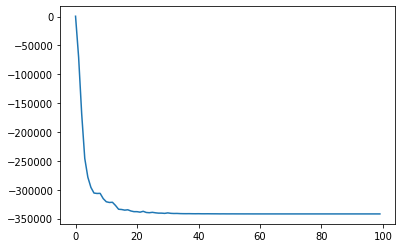

In [11]:
plt.plot(J)